In [12]:
import numpy as np
import time
import cv2
import matplotlib.pyplot as plt

In [2]:
from testers.helpers import get_all_area_maps, imshow, imshow_scatter

In [6]:
def stc_preprocess(area_map):
    """
    Returns matrix that in the form
    that is read by the main algorithm.
    """
    matrix = np.full(area_map.shape, 0, dtype=np.uint8)
    matrix[area_map == 0] = 255
    return matrix

In [35]:
def get_stc_path(matrix):
    bound = matrix.shape
    r = int(bound[0]/2)
    c = int(bound[1]/2)
    grid = [[((max(abs((r-1)/2-i), abs((c-1)/2-j))+1) if(all(pt for pg in matrix[2*i:2*(i+1),2*j:2*(j+1)] for pt in pg)) else -1) for j in range(c)] for i in range(r)]
    vertices = {}
    for i in range(r):
        for j in range(c):
            if grid[i][j]>=0:
                vertices[(i, j)] = None
    s = list(vertices.keys())[0]
#     time_split.append(time.time()-start_time)
#     start_time = time.time()
    
    pathf = []
    pathi = {}
    treef = {}
    tree = {}
    while len(vertices):
        pathi[s] = None
        del vertices[s]
        if s not in tree: tree[s] = np.full(4, 0)
        grid[s[0]][s[1]] = 0
        tmp = [0, 0, 0, 0]
        tmp[0] = grid[s[0]-1][s[1]] if s[0]-1>=0 and grid[s[0]-1][s[1]]!=-1 else -1
        tmp[1] = grid[s[0]][s[1]+1] if s[1]+1<c and grid[s[0]][s[1]+1]!=-1 else -1
        tmp[2] = grid[s[0]+1][s[1]] if s[0]+1<r and grid[s[0]+1][s[1]]!=-1 else -1
        tmp[3] = grid[s[0]][s[1]-1] if s[1]-1>=0 and grid[s[0]][s[1]-1]!=-1 else -1
        grt = max(tmp)
        if grt>0:
            ind = tmp.index(grt)
            s = (s[0]-1, s[1]) if ind==0 else (s[0], s[1]+1) if ind==1 else (s[0]+1, s[1]) if ind==2 else (s[0], s[1]-1)
        else:
            pathf.append(pathi)
            pathi = {}
            treef.update(tree)
            tree = {}
            if len(vertices.keys()):
                s = list(vertices.keys())[0]
#     time_split.append(time.time()-start_time)
#     start_time = time.time()
    
    a = np.array([len(i) for i in pathf])
    b = np.argsort(s)
    edgePath = [i for i in range(len(pathf))]
    edgeJoin = [set([i]) for i in range(len(pathf))]
    ejPath = []
    def whichPath(ver):
        for i in range(len(pathf)):
            if ver in pathf[i]: return i
        return 0

    def mergePath(ind1, v1, v2):
        ind2 = whichPath(v2)
        edgeJoin[edgePath[ind1]] = edgeJoin[edgePath[ind1]].union(edgeJoin[edgePath[ind2]])
        for i in edgeJoin[edgePath[ind2]]:
            edgePath[i] = edgePath[ind1]
        ejPath.append([v1, v2])

    for index in range(len(b)-1):
        i = b[index]
        for j in list(pathf[i].keys()):
            x, y = j
            if x-1>=0 and grid[x-1][y]!=-1 and not any((x-1, y) in pathf[ind] for ind in edgeJoin[edgePath[i]]):
                mergePath(i, j, (x-1, y))
            if y-1>=0 and grid[x][y-1]!=-1 and not any((x, y-1) in pathf[ind] for ind in edgeJoin[edgePath[i]]):
                mergePath(i, j, (x, y-1))
            if x+1<r and grid[x+1][y]!=-1 and not any((x+1, y) in pathf[ind] for ind in edgeJoin[edgePath[i]]):
                mergePath(i, j, (x+1, y))
            if y+1<c and grid[x][y+1]!=-1 and not any((x, y+1) in pathf[ind] for ind in edgeJoin[edgePath[i]]):
                mergePath(i, j, (x, y+1))

    for p in range(len(ejPath)):
        path = ejPath[p]
        ind = 0 if path[0][0]-1==path[1][0] else 1 if path[0][1]+1==path[1][1] else 2 if path[0][0]+1==path[1][0] else 3
        treef[path[0]][ind] = 1
        treef[path[1]][(ind+2)%4] = 1

#     time_split.append(time.time()-start_time)
#     start_time = time.time()
    
    for p in range(len(pathf)):
        path = list(pathf[p].keys())
        for i in range(1, len(path)):
            ind = 0 if path[i-1][0]-1==path[i][0] else 1 if path[i-1][1]+1==path[i][1] else 2 if path[i-1][0]+1==path[i][0] else 3
            treef[path[i-1]][ind] = 1
            treef[path[i]][(ind+2)%4] = 1
            
    finalPathf = []
    finalPath = []
    for i in set(edgePath):
        vertex = tuple(2*a for a in (list(pathf[i].keys())[0]))
        while True:
            finalPath.append(vertex)
            vertex_grid = tuple(int(a/2) for a in vertex)
            if vertex[0]%2==0 and vertex[1]%2==0:
                if treef[vertex_grid][0]:
                    vertex = (vertex[0]-1, vertex[1])
                else:
                    vertex = (vertex[0], vertex[1]+1)
            elif vertex[0]%2==0:
                if treef[vertex_grid][1]:
                    vertex = (vertex[0], vertex[1]+1)
                else:
                    vertex = (vertex[0]+1, vertex[1])
            elif vertex[1]%2==0:
                if treef[vertex_grid][3]:
                    vertex = (vertex[0], vertex[1]-1)
                else:
                    vertex = (vertex[0]-1, vertex[1])
            else:
                if treef[vertex_grid][2]:
                    vertex = (vertex[0]+1, vertex[1])
                else:
                    vertex = (vertex[0], vertex[1]-1)
            if vertex==finalPath[0]: 
                finalPath.append(vertex)
                break
        finalPathf.append(finalPath)
        finalPath = []

    return finalPathf
    
"""
Post proc
"""
#     for i in finalPathf:
#         for j in i:
#             matrix[j] = 127
#     print(cv2.imwrite((ImagePath+'Final.png'), matrix))
#     time_split.append(time.time()-start_time)
#     start_time = time.time()
    
#     total_time = time.time() - total_time
#     print(time_split, total_time)

'\nPost proc\n'

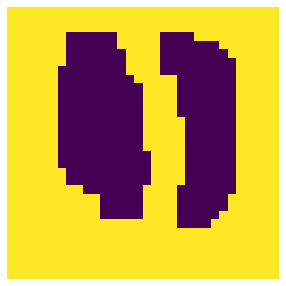

In [36]:
area_maps = get_all_area_maps("./test_maps/")
area_map = area_maps[1]
matrix = stc_preprocess(area_map)
imshow(matrix)

In [38]:
coverage_paths = get_stc_path(matrix)

In [46]:
(area_map == 0).sum()

689

In [47]:
np.sum([len(cp) for cp in coverage_paths])

623

3

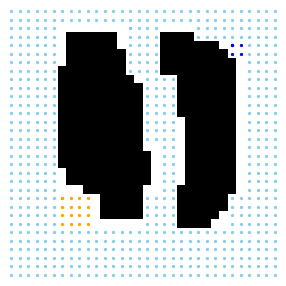

In [69]:
imshow(matrix, cmap="Greys_r")
# for coverage_path in coverage_paths:
imshow_scatter(coverage_paths[0], "skyblue",1, 5 )
imshow_scatter(coverage_paths[1], "blue",1, 5 )
imshow_scatter(coverage_paths[2], "orange",1, 5 )
len(coverage_paths)

In [70]:
for cp in coverage_paths[1]:
    if cp in coverage_paths[0]:
        print(cp)

In [74]:
for cp in coverage_paths[2]:
    if cp in coverage_paths[0]:
        print(cp)

In [55]:
for c in coverage_paths:
    print(c[0], c[-1])

(2, 14) (2, 14)
(4, 26) (4, 26)
(22, 6) (22, 6)


input is 0 for for obstacles and 255 for area to be covered.

In [21]:
def STC(ImagePath):
#     img = cv2.imread((ImagePath+".png"), 2)
    img = cv2.imread(ImagePath, 2)
    ret, matrix = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    bound = matrix.shape
    total_time = time.time()
    start_time = time.time()
    time_split = []
    
    r = int(bound[0]/2)
    c = int(bound[1]/2)
    grid = [[((max(abs((r-1)/2-i), abs((c-1)/2-j))+1) if(all(pt for pg in matrix[2*i:2*(i+1),2*j:2*(j+1)] for pt in pg)) else -1) for j in range(c)] for i in range(r)]
    vertices = {}
    for i in range(r):
        for j in range(c):
            if grid[i][j]>=0:
                vertices[(i, j)] = None
    s = list(vertices.keys())[0]
    time_split.append(time.time()-start_time)
    start_time = time.time()
    
    pathf = []
    pathi = {}
    treef = {}
    tree = {}
    while len(vertices):
        pathi[s] = None
        del vertices[s]
        if s not in tree: tree[s] = np.full(4, 0)
        grid[s[0]][s[1]] = 0
        tmp = [0, 0, 0, 0]
        tmp[0] = grid[s[0]-1][s[1]] if s[0]-1>=0 and grid[s[0]-1][s[1]]!=-1 else -1
        tmp[1] = grid[s[0]][s[1]+1] if s[1]+1<c and grid[s[0]][s[1]+1]!=-1 else -1
        tmp[2] = grid[s[0]+1][s[1]] if s[0]+1<r and grid[s[0]+1][s[1]]!=-1 else -1
        tmp[3] = grid[s[0]][s[1]-1] if s[1]-1>=0 and grid[s[0]][s[1]-1]!=-1 else -1
        grt = max(tmp)
        if grt>0:
            ind = tmp.index(grt)
            s = (s[0]-1, s[1]) if ind==0 else (s[0], s[1]+1) if ind==1 else (s[0]+1, s[1]) if ind==2 else (s[0], s[1]-1)
        else:
            pathf.append(pathi)
            pathi = {}
            treef.update(tree)
            tree = {}
            if len(vertices.keys()):
                s = list(vertices.keys())[0]
    time_split.append(time.time()-start_time)
    start_time = time.time()
    
    a = np.array([len(i) for i in pathf])
    b = np.argsort(s)
    edgePath = [i for i in range(len(pathf))]
    edgeJoin = [set([i]) for i in range(len(pathf))]
    ejPath = []
    def whichPath(ver):
        for i in range(len(pathf)):
            if ver in pathf[i]: return i
        return 0

    def mergePath(ind1, v1, v2):
        ind2 = whichPath(v2)
        edgeJoin[edgePath[ind1]] = edgeJoin[edgePath[ind1]].union(edgeJoin[edgePath[ind2]])
        for i in edgeJoin[edgePath[ind2]]:
            edgePath[i] = edgePath[ind1]
        ejPath.append([v1, v2])
        #print(v1, "-", v2, " - ", edgePath, " ~ ", edgeJoin)

    for index in range(len(b)-1):
        i = b[index]
        for j in list(pathf[i].keys()):
            x, y = j
            if x-1>=0 and grid[x-1][y]!=-1 and not any((x-1, y) in pathf[ind] for ind in edgeJoin[edgePath[i]]):
                mergePath(i, j, (x-1, y))
            if y-1>=0 and grid[x][y-1]!=-1 and not any((x, y-1) in pathf[ind] for ind in edgeJoin[edgePath[i]]):
                mergePath(i, j, (x, y-1))
            if x+1<r and grid[x+1][y]!=-1 and not any((x+1, y) in pathf[ind] for ind in edgeJoin[edgePath[i]]):
                mergePath(i, j, (x+1, y))
            if y+1<c and grid[x][y+1]!=-1 and not any((x, y+1) in pathf[ind] for ind in edgeJoin[edgePath[i]]):
                mergePath(i, j, (x, y+1))

    for p in range(len(ejPath)):
        path = ejPath[p]
        ind = 0 if path[0][0]-1==path[1][0] else 1 if path[0][1]+1==path[1][1] else 2 if path[0][0]+1==path[1][0] else 3
        treef[path[0]][ind] = 1
        treef[path[1]][(ind+2)%4] = 1

    time_split.append(time.time()-start_time)
    start_time = time.time()
    
    for p in range(len(pathf)):
        path = list(pathf[p].keys())
        for i in range(1, len(path)):
            ind = 0 if path[i-1][0]-1==path[i][0] else 1 if path[i-1][1]+1==path[i][1] else 2 if path[i-1][0]+1==path[i][0] else 3
            treef[path[i-1]][ind] = 1
            treef[path[i]][(ind+2)%4] = 1
            
    finalPathf = []
    finalPath = []
    for i in set(edgePath):
        vertex = tuple(2*a for a in (list(pathf[i].keys())[0]))
        while True:
            finalPath.append(vertex)
            vertex_grid = tuple(int(a/2) for a in vertex)
            if vertex[0]%2==0 and vertex[1]%2==0:
                if treef[vertex_grid][0]:
                    vertex = (vertex[0]-1, vertex[1])
                else:
                    vertex = (vertex[0], vertex[1]+1)
            elif vertex[0]%2==0:
                if treef[vertex_grid][1]:
                    vertex = (vertex[0], vertex[1]+1)
                else:
                    vertex = (vertex[0]+1, vertex[1])
            elif vertex[1]%2==0:
                if treef[vertex_grid][3]:
                    vertex = (vertex[0], vertex[1]-1)
                else:
                    vertex = (vertex[0]-1, vertex[1])
            else:
                if treef[vertex_grid][2]:
                    vertex = (vertex[0]+1, vertex[1])
                else:
                    vertex = (vertex[0], vertex[1]-1)
            if vertex==finalPath[0]: 
                finalPath.append(vertex)
                break
        finalPathf.append(finalPath)
        finalPath = []

    for i in finalPathf:
        for j in i:
            matrix[j] = 127
#     print(cv2.imwrite((ImagePath+'Final.png'), matrix))
    imshow(matrix)
    
    time_split.append(time.time()-start_time)
    start_time = time.time()
    
    total_time = time.time() - total_time
    print(time_split, total_time)